Starting analysis of rhythm factors in the FastShip scenario...
Rhythm Factor Analysis - FastShip Logistics Scenario

1. Rhythm Factor Extraction Results:
   Used 10 time features
   Extracted 3 rhythm factors
   Explained variance ratio: [9.9756168e-01 1.8843893e-03 4.0153308e-04]
   Cumulative explained variance: 1.000

2. Rhythm Factor Loading Analysis (Top 3 by absolute value):
   Rhythm Factor 1:
     - day_of_year: 0.990
     - week_of_year: 0.135
     - month: 0.032
   Rhythm Factor 2:
     - week_of_year: 0.990
     - day_of_year: -0.136
     - day_of_week: 0.019
   Rhythm Factor 3:
     - day_of_week: 0.946
     - sin_day: -0.258
     - is_holiday: 0.157

3. Rhythm Pattern Clustering:
                order_quantity  delivery_time  satisfaction  is_holiday  \
rhythm_cluster                                                            
0                        53.28          10.22          4.20        0.35   
1                        58.11           9.69          4.31        0.34 

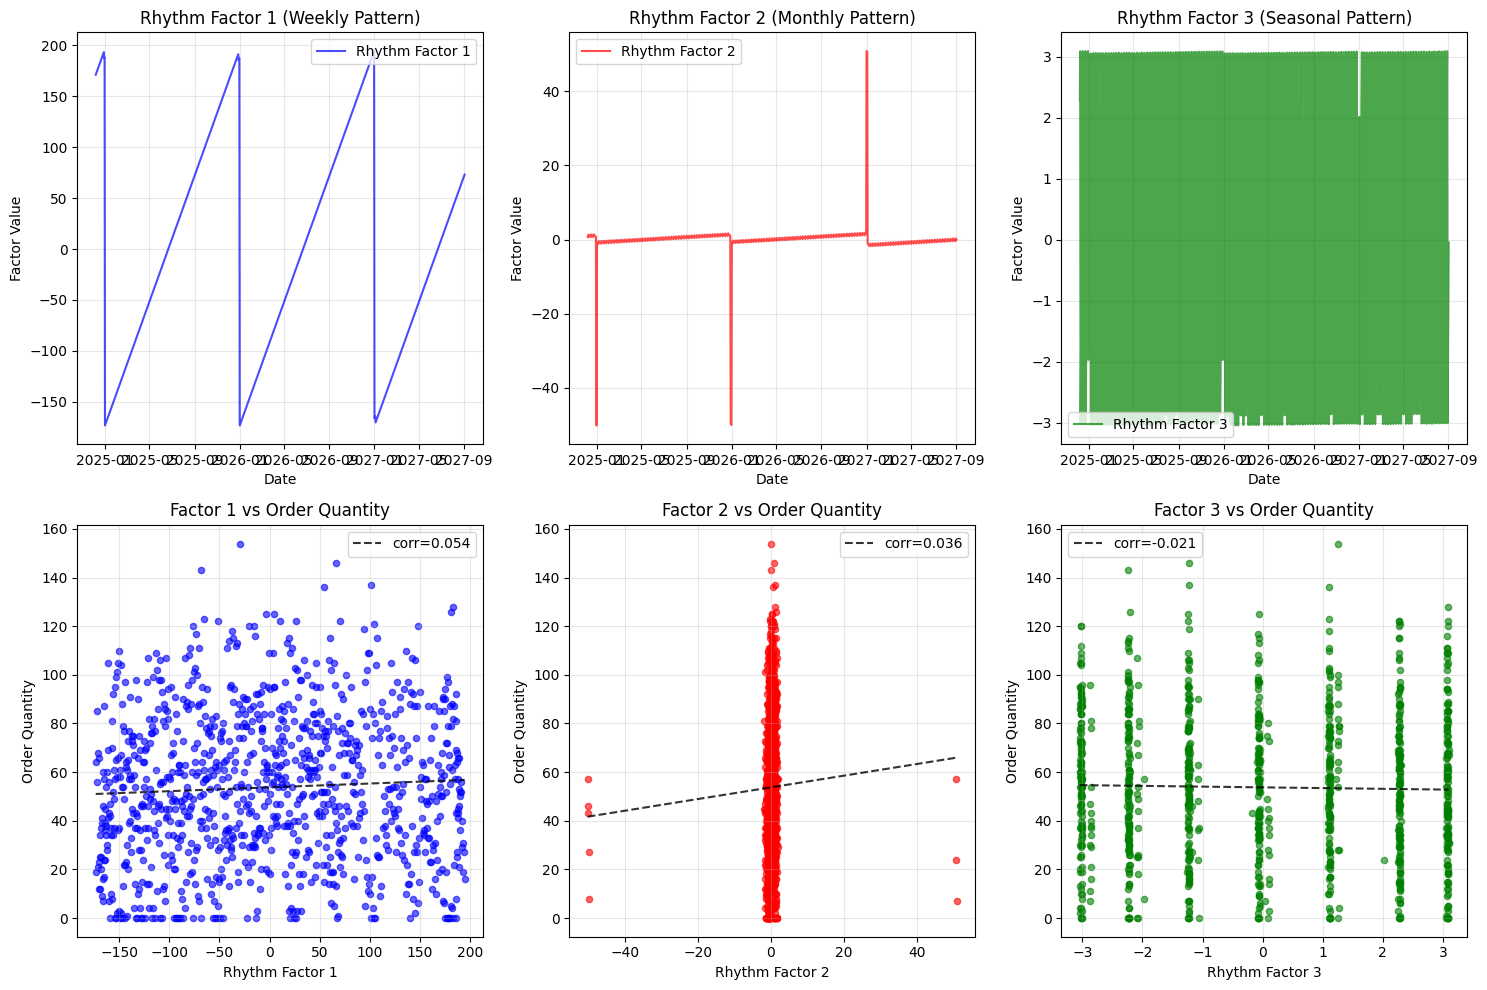


5. Scheduling Decision Recommendations

Scheduling Recommendations for Each Rhythm Pattern:

  Pattern 0:
    • Average order quantity: 53.3
    • Average delivery time: 10.2 minutes
    • Holiday ratio: 0.35
    → Recommendation: Holiday mode, schedule on-duty personnel in advance

  Pattern 1:
    • Average order quantity: 58.1
    • Average delivery time: 9.7 minutes
    • Holiday ratio: 0.34
    → Recommendation: Holiday mode, schedule on-duty personnel in advance

  Pattern 2:
    • Average order quantity: 49.7
    • Average delivery time: 10.0 minutes
    • Holiday ratio: 0.39
    → Recommendation: Holiday mode, schedule on-duty personnel in advance

6. Rhythm Factor Intervention Simulation
   (Assuming we can adjust rhythm factors):
   Current average rhythm prediction:
     • Predicted order quantity: 68.1
     • Predicted delivery time: 9.6 minutes

   Rhythm Optimization Recommendations:
     • Rhythm Factor 1: Recommend to Decrease to improve satisfaction (correlation: -0.0

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

def analyze_rhythm_factors(data_path='fastship_dataset.csv'):
    """
    Identify implicit "rhythm factors" in the FastShip scenario and analyze their impact on scheduling decisions.

    Input parameters:
    - data_path: Path to the dataset

    Output:
    - Rhythm factor identification results
    - Analysis of rhythm factors' impact on key metrics
    - Scheduling decision recommendations

    Main functionality:
    Use unsupervised methods to discover temporal rhythm patterns in the data and analyze their impact on logistics scheduling.
    """
    # 1. Load data
    df = pd.read_csv(data_path)

    # Add time features
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['week_of_year'] = df['date'].dt.isocalendar().week

    print("="*60)
    print("Rhythm Factor Analysis - FastShip Logistics Scenario")
    print("="*60)

    # 2. Identify temporal rhythm patterns
    # Use time series features
    time_features = ['day_of_week', 'day_of_year', 'week_of_year', 'month',
                     'is_holiday', 'is_promotion']

    # Add cyclical features
    df['sin_day'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_day'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    # Expand time features
    extended_time_features = time_features + ['sin_day', 'cos_day', 'sin_month', 'cos_month']

    # 3. Use PCA to extract rhythm factors
    X_time = df[extended_time_features].values

    pca = PCA(n_components=3)
    rhythm_factors = pca.fit_transform(X_time)

    df['rhythm_factor1'] = rhythm_factors[:, 0]
    df['rhythm_factor2'] = rhythm_factors[:, 1]
    df['rhythm_factor3'] = rhythm_factors[:, 2]

    print("\n1. Rhythm Factor Extraction Results:")
    print(f"   Used {len(extended_time_features)} time features")
    print(f"   Extracted 3 rhythm factors")
    print(f"   Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"   Cumulative explained variance: {sum(pca.explained_variance_ratio_):.3f}")

    # 4. Interpret the meaning of rhythm factors
    # Analyze PCA loadings
    loadings = pd.DataFrame(
        pca.components_,
        columns=extended_time_features,
        index=[f'RhythmFactor{i+1}' for i in range(3)]
    )

    print("\n2. Rhythm Factor Loading Analysis (Top 3 by absolute value):")
    for i in range(3):
        factor_loadings = loadings.iloc[i].abs().sort_values(ascending=False)
        top_features = factor_loadings.head(3)
        print(f"   Rhythm Factor {i+1}:")
        for feat, loading in top_features.items():
            original_loading = loadings.iloc[i][feat]
            print(f"     - {feat}: {original_loading:.3f}")

    # 5. Cluster analysis of rhythm factors
    kmeans = KMeans(n_clusters=3, random_state=42)
    rhythm_clusters = kmeans.fit_predict(rhythm_factors)
    df['rhythm_cluster'] = rhythm_clusters

    print("\n3. Rhythm Pattern Clustering:")
    cluster_stats = df.groupby('rhythm_cluster').agg({
        'order_quantity': 'mean',
        'delivery_time': 'mean',
        'satisfaction': 'mean',
        'is_holiday': 'mean',
        'is_promotion': 'mean'
    }).round(2)

    print(cluster_stats)

    # 6. Analyze the impact of rhythm factors on scheduling metrics
    print("\n4. Analysis of Rhythm Factors' Impact on Key Metrics:")

    # Prepare features and target variables
    X = df[['rhythm_factor1', 'rhythm_factor2', 'rhythm_factor3',
            'weather_impact', 'geo_cluster_encoded']].values
    y_order = df['order_quantity'].values
    y_time = df['delivery_time'].values

    # Train Random Forest models to evaluate feature importance
    rf_order = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_order.fit(X, y_order)

    rf_time = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_time.fit(X, y_time)

    feature_names = ['Rhythm1', 'Rhythm2', 'Rhythm3', 'Weather', 'GeoCluster']

    print("\n   A. Impact on Order Quantity (Feature Importance):")
    order_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_order.feature_importances_
    }).sort_values('importance', ascending=False)

    for _, row in order_importance.iterrows():
        print(f"     {row['feature']}: {row['importance']:.3f}")

    print("\n   B. Impact on Delivery Time (Feature Importance):")
    time_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_time.feature_importances_
    }).sort_values('importance', ascending=False)

    for _, row in time_importance.iterrows():
        print(f"     {row['feature']}: {row['importance']:.3f}")

    # 7. Visualize results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Rhythm factors over time
    axes[0, 0].plot(df['date'], df['rhythm_factor1'], 'b-', alpha=0.7, label='Rhythm Factor 1')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Factor Value')
    axes[0, 0].set_title('Rhythm Factor 1 (Weekly Pattern)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    axes[0, 1].plot(df['date'], df['rhythm_factor2'], 'r-', alpha=0.7, label='Rhythm Factor 2')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Factor Value')
    axes[0, 1].set_title('Rhythm Factor 2 (Monthly Pattern)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    axes[0, 2].plot(df['date'], df['rhythm_factor3'], 'g-', alpha=0.7, label='Rhythm Factor 3')
    axes[0, 2].set_xlabel('Date')
    axes[0, 2].set_ylabel('Factor Value')
    axes[0, 2].set_title('Rhythm Factor 3 (Seasonal Pattern)')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].legend()

    # Relationship between rhythm factors and order quantity
    for i, color in enumerate(['blue', 'red', 'green']):
        axes[1, i].scatter(df[f'rhythm_factor{i+1}'], df['order_quantity'],
                          alpha=0.6, c=color, s=20)
        axes[1, i].set_xlabel(f'Rhythm Factor {i+1}')
        axes[1, i].set_ylabel('Order Quantity')
        axes[1, i].set_title(f'Factor {i+1} vs Order Quantity')
        axes[1, i].grid(True, alpha=0.3)

        # Add trend line
        z = np.polyfit(df[f'rhythm_factor{i+1}'], df['order_quantity'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(df[f'rhythm_factor{i+1}'].min(),
                              df[f'rhythm_factor{i+1}'].max(), 100)
        axes[1, i].plot(x_range, p(x_range), 'k--', alpha=0.8,
                       label=f'corr={np.corrcoef(df[f"rhythm_factor{i+1}"], df["order_quantity"])[0,1]:.3f}')
        axes[1, i].legend()

    plt.tight_layout()
    plt.savefig('rhythm_factor_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 8. Scheduling decision recommendations
    print("\n" + "="*60)
    print("5. Scheduling Decision Recommendations")
    print("="*60)

    # Provide scheduling recommendations based on rhythm factors
    rhythm_stats = df.groupby('rhythm_cluster').agg({
        'order_quantity': ['mean', 'std'],
        'delivery_time': ['mean', 'std']
    }).round(2)

    print("\nScheduling Recommendations for Each Rhythm Pattern:")

    for cluster in sorted(df['rhythm_cluster'].unique()):
        cluster_data = df[df['rhythm_cluster'] == cluster]
        avg_orders = cluster_data['order_quantity'].mean()
        avg_time = cluster_data['delivery_time'].mean()
        holiday_ratio = cluster_data['is_holiday'].mean()

        print(f"\n  Pattern {cluster}:")
        print(f"    • Average order quantity: {avg_orders:.1f}")
        print(f"    • Average delivery time: {avg_time:.1f} minutes")
        print(f"    • Holiday ratio: {holiday_ratio:.2f}")

        # Provide specific recommendations
        if avg_orders > df['order_quantity'].mean() * 1.2:
            print(f"    → Recommendation: Increase resource allocation, prepare additional 20% resources")
        elif avg_orders < df['order_quantity'].mean() * 0.8:
            print(f"    → Recommendation: Perform equipment maintenance or staff training")

        if avg_time > df['delivery_time'].mean() * 1.15:
            print(f"    → Recommendation: Optimize route planning, consider alternative routes")

        if holiday_ratio > 0.3:
            print(f"    → Recommendation: Holiday mode, schedule on-duty personnel in advance")

    # 9. Rhythm factor intervention simulation
    print("\n6. Rhythm Factor Intervention Simulation")
    print("   (Assuming we can adjust rhythm factors):")

    # Find the optimal rhythm factor combination
    X_test = np.array([[df['rhythm_factor1'].mean(),
                       df['rhythm_factor2'].mean(),
                       df['rhythm_factor3'].mean(),
                       df['weather_impact'].mean(),
                       df['geo_cluster_encoded'].mean()]])

    pred_order = rf_order.predict(X_test)[0]
    pred_time = rf_time.predict(X_test)[0]

    print(f"   Current average rhythm prediction:")
    print(f"     • Predicted order quantity: {pred_order:.1f}")
    print(f"     • Predicted delivery time: {pred_time:.1f} minutes")

    # Simulate optimizing rhythm factors
    print(f"\n   Rhythm Optimization Recommendations:")

    # Analyze the optimal direction for each rhythm factor
    for i in range(3):
        # Analyze relationship between rhythm factor and satisfaction
        corr_with_satisfaction = np.corrcoef(df[f'rhythm_factor{i+1}'], df['satisfaction'])[0, 1]
        if corr_with_satisfaction > 0:
            direction = "Increase"
        else:
            direction = "Decrease"

        print(f"     • Rhythm Factor {i+1}: Recommend to {direction} to improve satisfaction (correlation: {corr_with_satisfaction:.3f})")

    return df, rhythm_factors, cluster_stats

# Run rhythm factor analysis
if __name__ == "__main__":
    print("Starting analysis of rhythm factors in the FastShip scenario...")
    df_result, rhythm_factors, cluster_stats = analyze_rhythm_factors('fastship_dataset.csv')

    print("\n" + "="*60)
    print("Analysis completed!")